<a href="https://colab.research.google.com/github/afifaniks/aEyeSystem/blob/master/model_training_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Footpath Detection using Semantic Segmentation (UNET)
Author: [Afif Al Mamun](https://afifaniks.github.io) <br>
Date: November 24, 2019 <br>
\[Revisited\]: September 2020

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp '/content/drive/My Drive/aEye/datasets/dataset_256x256_6000_blur.zip' .

In [4]:
!unzip dataset_256x256_6000_blur.zip

Archive:  dataset_256x256_6000_blur.zip
replace images/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
!pip install keras-unet
!pip install extra_keras_metrics

  Created wheel for extra-keras-metrics: filename=extra_keras_metrics-1.3.1-cp36-none-any.whl size=13091 sha256=25c7bfd322fc9559ca9ef3ee2380311eb1e16cb97c3cd609a0db2db742a11e86
  Stored in directory: /root/.cache/pip/wheels/48/f1/b4/a9f81578416b99274b6d5b34fdc92d9bd82b6be99efa965b17
Successfully built extra-keras-metrics


In [6]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
%tensorflow_version 1.15
import tensorflow as tf
import keras as K
from keras import regularizers
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras_unet.metrics import iou, iou_thresholded, dice_coef
import extra_keras_metrics as ekm
from keras.layers import Flatten

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
-----------------------------------------
keras-unet init: TF version is < 2.0.0 or not present - using `Keras` instead of `tf.keras`
-----------------------------------------


Using TensorFlow backend.


In [7]:
# Set some parameters
im_width = 256
im_height = 256
# border = 5

In [8]:
ids = next(os.walk("images"))[2]
print("No of images: ", len(ids))

No of images:  6000


In [9]:
img_p = 'images'
msk_p = 'masks'

In [10]:
img = load_img(img_p + '/11.jpg', color_mode='grayscale')
x_img = img_to_array(img)
len(x_img)

256

In [11]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [12]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(img_p+"/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img(msk_p+"/"+id_, grayscale=True))
    mask = resize(mask, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [13]:
tf.__version__

'1.15.2'

In [71]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Image augmentation

Text(0.5, 1.0, 'Footpath')

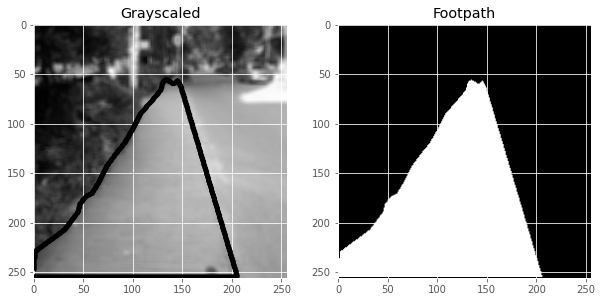

In [16]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # Footpath indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))


ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating footpath and non-footpath areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Grayscaled')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Footpath')

In [67]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

     # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [68]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, k_size=3):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [69]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=32, dropout=0.1, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", iou, iou_thresholded, dice_coef, ekm.precision, ekm.recall])

In [70]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, 256, 256, 32) 320         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, 256, 256, 32) 128         conv2d_79[0][0]                  
__________________________________________________________________________________________________
activation_76 (Activation)      (None, 256, 256, 32) 0           batch_normalization_76[0][0]     
____________________________________________________________________________________________

In [72]:
callbacks = [
    EarlyStopping(patience=15, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('footpath.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [73]:
batch_size = 15

In [74]:
results = model.fit(X_train, y_train, batch_size=batch_size, epochs=100, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 4800 samples, validate on 1200 samples
Epoch 1/100
4800/4800 [==============================] - 54s 11ms/step - loss: 0.2483 - accuracy: 0.8761 - iou: 0.5861 - iou_thresholded: 0.6999 - dice_coef: 0.7359 - precision: 0.7747 - recall: 0.7659 - val_loss: 0.4334 - val_accuracy: 0.8274 - val_iou: 0.6119 - val_iou_thresholded: 0.6462 - val_dice_coef: 0.7581 - val_precision: 0.8018 - val_recall: 0.8219

Epoch 00001: val_loss improved from inf to 0.43343, saving model to footpath.h5
Epoch 2/100
4800/4800 [==============================] - 52s 11ms/step - loss: 0.1925 - accuracy: 0.9021 - iou: 0.6686 - iou_thresholded: 0.7649 - dice_coef: 0.8007 - precision: 0.8062 - recall: 0.8368 - val_loss: 0.3933 - val_accuracy: 0.8484 - val_iou: 0.6533 - val_iou_thresholded: 0.6809 - val_dice_coef: 0.7890 - val_precision: 0.8142 - val_recall: 0.8454

Epoch 00002: val_loss improved from 0.43343 to 0.39327, saving model to footpath.h5
Epoch 3/100
4800/4800 [==============================] - 52s 11m

In [75]:
best_model = np.argmin(results.history["val_loss"])

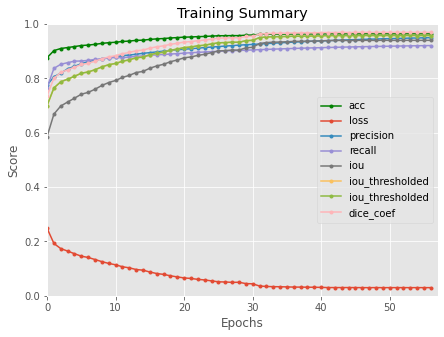

In [94]:
plt.figure(figsize=(7, 5))
plt.title("Training Summary")
plt.xlim(0, 57)
plt.ylim(0, 1)
plt.plot(results.history["accuracy"], label="acc", color='g', marker = '.')
plt.plot(results.history["loss"], label="loss", marker = '.')
plt.plot(results.history["precision"], label="precision", marker = '.')
plt.plot(results.history["recall"], label="recall", marker = '.')
plt.plot(results.history["iou"], label="iou", marker = '.')
plt.plot(results.history["iou_thresholded"], label="iou_thresholded", marker = '.')
plt.plot(results.history["iou_thresholded"], label="iou_thresholded", marker = '.')
plt.plot(results.history["dice_coef"], label="dice_coef", marker = '.')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend();

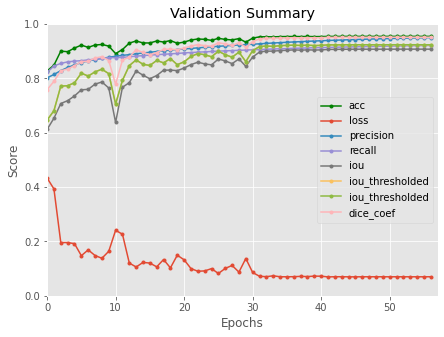

In [96]:
plt.figure(figsize=(7, 5))
plt.title("Validation Summary")
plt.xlim(0, 57)
plt.ylim(0, 1)
plt.plot(results.history["val_accuracy"], label="acc", color='g', marker = '.')
plt.plot(results.history["val_loss"], label="loss", marker = '.')
plt.plot(results.history["val_precision"], label="precision", marker = '.')
plt.plot(results.history["val_recall"], label="recall", marker = '.')
plt.plot(results.history["val_iou"], label="iou", marker = '.')
plt.plot(results.history["val_iou_thresholded"], label="iou_thresholded", marker = '.')
plt.plot(results.history["val_iou_thresholded"], label="iou_thresholded", marker = '.')
plt.plot(results.history["val_dice_coef"], label="dice_coef", marker = '.')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend();

In [78]:
# load the best model
model.load_weights('footpath.h5')

In [79]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

1200/1200 [==============================] - 4s 3ms/step


[0.06954742858807246,
 0.9543470144271851,
 0.9063331484794617,
 0.9230731129646301,
 0.9507953524589539,
 0.9500957131385803,
 0.9209161996841431]

In [80]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

1200/1200 [==============================] - 4s 3ms/step


In [81]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [82]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Grayscaled')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Footpath')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Footpath Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Footpath Predicted binary');

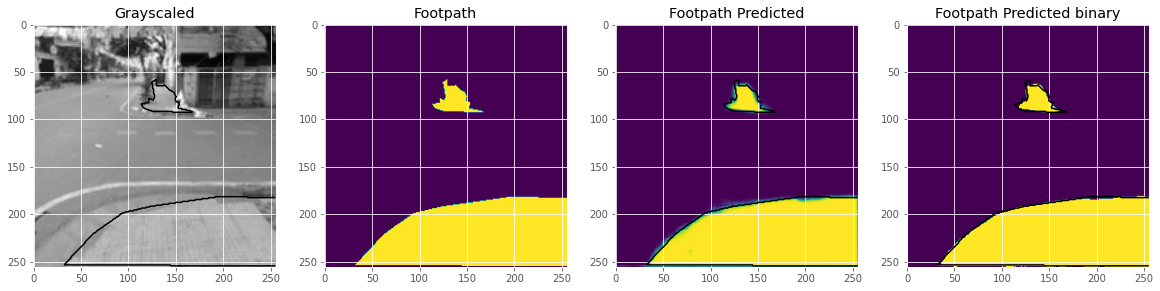

In [83]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

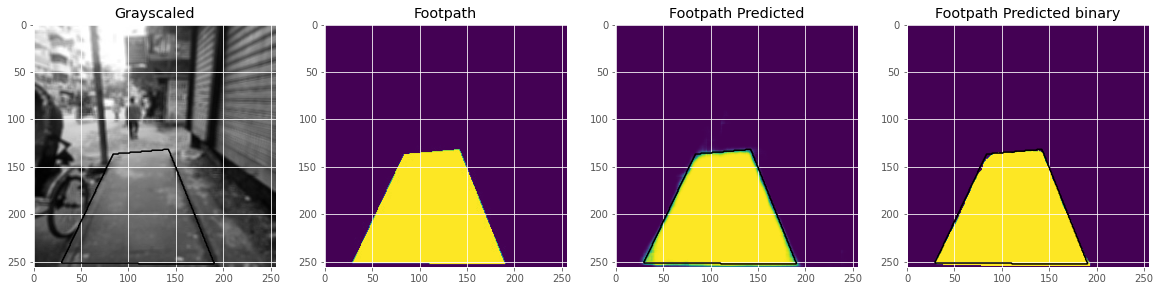

In [84]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

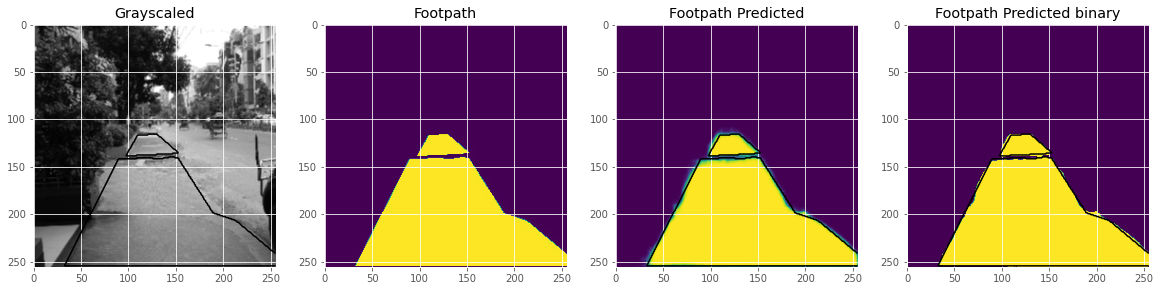

In [85]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

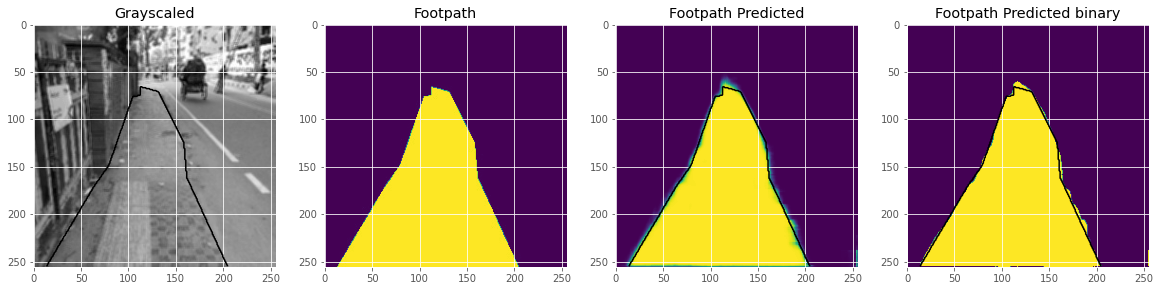

In [86]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

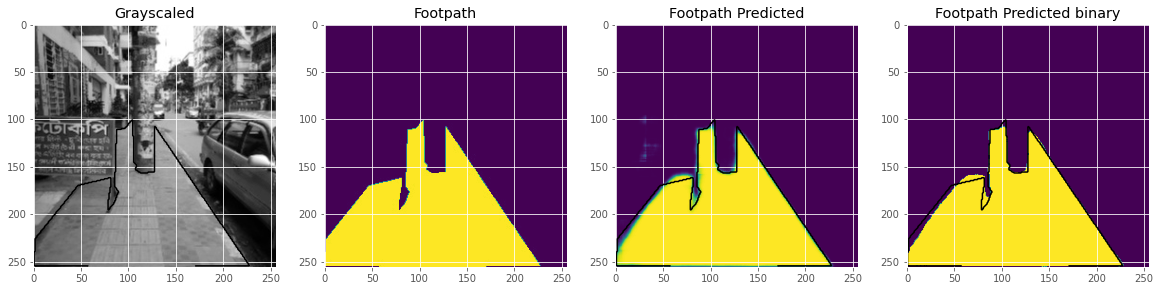

In [88]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

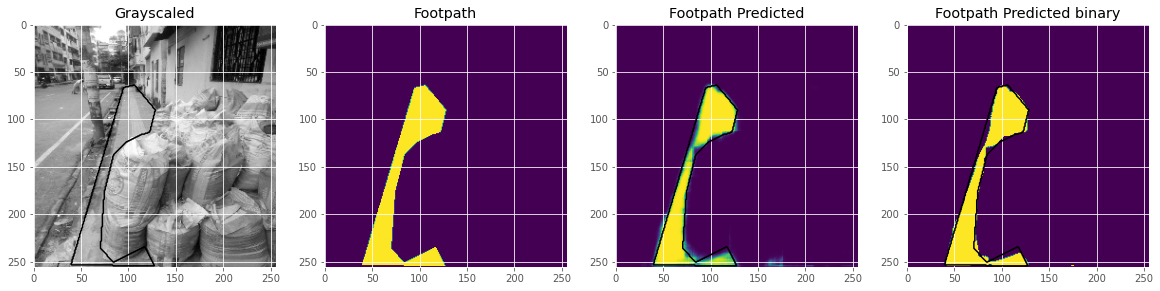

In [89]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

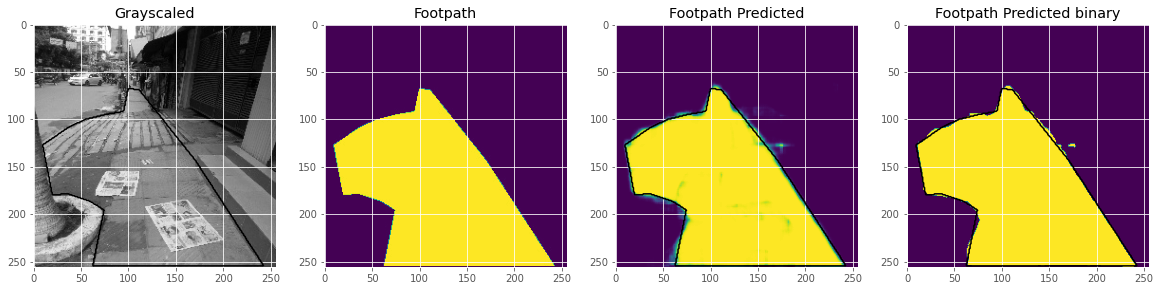

In [90]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

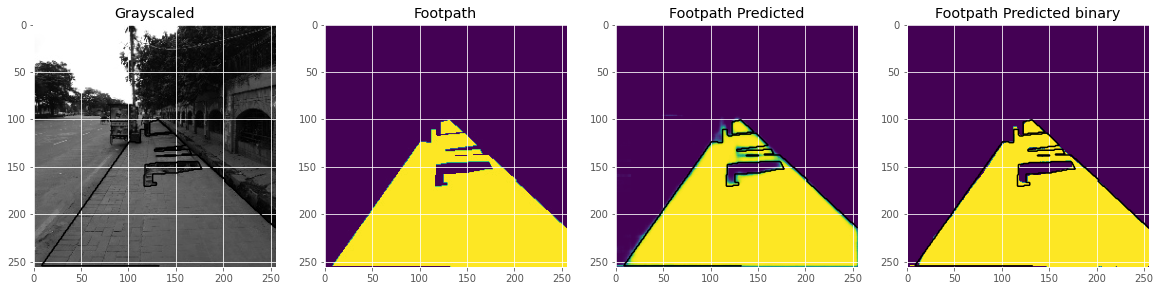

In [91]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

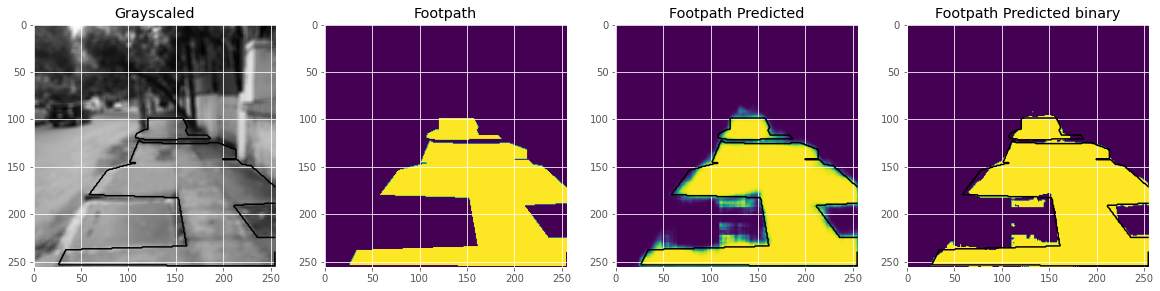

In [92]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

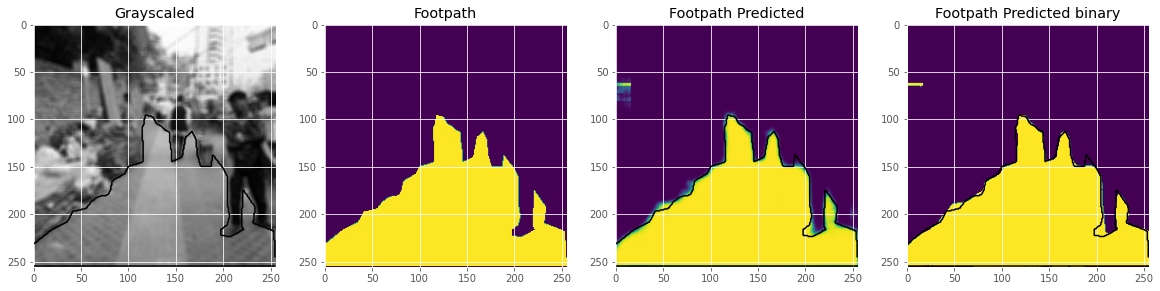

In [93]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)